## Contents
* read data
* drop redeundant columns
* one-hot encoding
* sliding window method
* identify response variable and predictors
* split into training and testing datasets
* data normalisation of training datasets
* define the model
* choose hyperparameters to tune
* identify the best hyperparameters using gridsearch
* make predictions based on these hyperparameters
* assess model performance 

In [ ]:
# Install required packages. Note only run if you receive error(s) when importing below.
# !pip install xgboost
# !pip install shap

In [5]:
import os
import pandas as pd
import numpy as np
import xgboost as xgb
from sklearn.metrics import mean_absolute_error, mean_squared_error, r2_score, accuracy_score
from sklearn.model_selection import train_test_split, GridSearchCV
from sklearn.preprocessing import MinMaxScaler, OneHotEncoder
import warnings
warnings.filterwarnings("ignore")

import shap

In [2]:
# base_dir = os.path.dirname(os.path.abspath("..\data"))
# path = os.path.join(base_dir, r"data")
# os.chdir(path) 

In [6]:
# data = pd.read_csv("Cleaned data\data.csv")
data = pd.read_csv("data.csv")

In [7]:
# drop columns
df = data.drop(columns=[
    "DATE","FORECASTDEMAND","MONTHDATE","MIN","ACCMIN","MAX","ACCMAX","RAINPERIOD","QUANTITY","QUANTITYMONTHCUM","QUANTITYTOTALCUM","HUMIDITYMIN","HUMIDITYMAX", "RAIN", "WEEKEND"
], errors="ignore")
df.head()

,YEAR,MONTH,DAY,HUMIDITY,WINDSPEED,TOTALDEMAND,HOLIDAY,SOLAR,TEMPAVE,RRP,OUTPUT,WEEKDAY
0,2016,1,1,0.656341,15.902439,6853.633437,2.0,32.2,21.95,38.472917,23.465,4
1,2016,1,2,0.656341,15.902439,6727.613958,0.0,21.7,21.00,36.907292,23.465,5
2,2016,1,3,0.688837,14.488372,6616.406076,0.0,10.3,21.55,31.997083,23.465,6
3,2016,1,4,0.679545,22.477273,7367.750278,0.0,6.4,20.90,33.424583,23.465,0
4,2016,1,5,0.768837,22.581395,7462.242014,0.0,4.4,19.05,33.053958,23.465,1


In [8]:
#one hot encoding weekday
def one_hot_encode(df, col, names):
    array = np.array(df[col])
    integer_encoded = array.reshape(len(array), 1)
    onehotencoder = OneHotEncoder()
    onehot_encoded = onehotencoder.fit_transform(integer_encoded).toarray()
    df_encoded = pd.DataFrame(onehot_encoded, columns=names)
    df = pd.concat([df, df_encoded], axis=1)
    df = df.drop(columns=[col], errors="ignore")
    return df

df = one_hot_encode(df, col="WEEKDAY", names=['MON', 'TUE', 'WED', 'THU', 'FRI', 'SAT', 'SUN'])
df.head()

,YEAR,MONTH,DAY,HUMIDITY,WINDSPEED,TOTALDEMAND,HOLIDAY,SOLAR,TEMPAVE,RRP,OUTPUT,MON,TUE,WED,THU,FRI,SAT,SUN
0,2016,1,1,0.656341,15.902439,6853.633437,2.0,32.2,21.95,38.472917,23.465,0.0,0.0,0.0,0.0,1.0,0.0,0.0
1,2016,1,2,0.656341,15.902439,6727.613958,0.0,21.7,21.00,36.907292,23.465,0.0,0.0,0.0,0.0,0.0,1.0,0.0
2,2016,1,3,0.688837,14.488372,6616.406076,0.0,10.3,21.55,31.997083,23.465,0.0,0.0,0.0,0.0,0.0,0.0,1.0
3,2016,1,4,0.679545,22.477273,7367.750278,0.0,6.4,20.90,33.424583,23.465,1.0,0.0,0.0,0.0,0.0,0.0,0.0
4,2016,1,5,0.768837,22.581395,7462.242014,0.0,4.4,19.05,33.053958,23.465,0.0,1.0,0.0,0.0,0.0,0.0,0.0


In [9]:
# function to create the sliding window dataset 
def create_sliding_window(data, window_size, step_size, target):
    X = []
    y = []
    for i in range(window_size, len(data)):
        X_window = []
        for j in range(0, window_size, step_size):
            X_window.append(data.iloc[i-j-1, :])
        X.append(np.concatenate(X_window, axis=0))
        y.append(data.iloc[i, :]) 
    y2 = [vals[5] for vals in y]
    # display(pd.DataFrame(X))
    return pd.DataFrame(X), pd.DataFrame(y2)

In [10]:
# Define the window size and step size
target = "TOTALDEMAND"
window_size = 1   # 1 day ahead
step_size = 1     # move the window by 1 day at a time

# Apply the sliding window method
X, y = create_sliding_window(df, window_size, step_size, target)
X_all = X.copy() #save for accuracy plotting
X = X.iloc[:, 1:]

In [11]:
# train test split - use last year to train (data ends in 08/2022 so set timeframe as 08/2021 to 08/2022)
test_timeframe = df.loc[np.where(((df['YEAR'] == 2021) & (df['MONTH'] > 7)) | (df['YEAR'] == 2022))]
test_len = len(test_timeframe)
X_train, X_test = X.head(len(X)-test_len), X.tail(test_len)
y_train, y_test = y.head(len(X)-test_len), y.tail(test_len)

In [12]:
# define scaler and transform data
scaler = MinMaxScaler()
X_train_scaled = pd.DataFrame(scaler.fit_transform(X_train))
X_test_scaled = pd.DataFrame(scaler.fit_transform(X_test))

In [13]:
# Define the XGBoost model
model = xgb.XGBRegressor()

In [16]:
# hyperparameters
params = {
    'n_estimators': [180, 200, 220],
    'max_depth': [3, 4, 5, 6],
    'learning_rate': [0.05, 0.1],
    'subsample': [0.8, 0.9],
    'colsample_bytree': [0.8, 0.9],
    'gamma': [0.001],
    'reg_alpha': [3, 4, 5],
    'reg_lambda': [4, 5, 6]
}

In [19]:
# identify best hyperparameters using gridsearch 
grid = GridSearchCV(model, params, cv=5, n_jobs=-1)
grid.fit(X_train_scaled, y_train) 

GridSearchCV(cv=5,
             estimator=XGBRegressor(base_score=None, booster=None,
                                    callbacks=None, colsample_bylevel=None,
                                    colsample_bynode=None,
                                    colsample_bytree=None,
                                    early_stopping_rounds=None,
                                    enable_categorical=False, eval_metric=None,
                                    feature_types=None, gamma=None, gpu_id=None,
                                    grow_policy=None, importance_type=None,
                                    interaction_constraints=None,
                                    learning_rate=None, m...
                                    min_child_weight=None, missing=nan,
                                    monotone_constraints=None, n_estimators=100,
                                    n_jobs=None, num_parallel_tree=None,
                                    predictor=None, random_state=N

In [20]:
# best hyperparameters and score 
print("Best Hyperparameters: ", grid.best_params_)
print("Best Score: ", grid.best_score_) 

# prev Best Hyperparameters:  {'colsample_bytree': 0.8, 'gamma': 0.001, 'learning_rate': 0.05, 'max_depth': 4, 'n_estimators': 220, 'reg_alpha': 4, 'reg_lambda': 5, 'subsample': 0.8}
# prev Best Score: 0.8237249155825339


Best Hyperparameters:  {'colsample_bytree': 0.8, 'gamma': 0.001, 'learning_rate': 0.05, 'max_depth': 5, 'n_estimators': 220, 'reg_alpha': 4, 'reg_lambda': 5, 'subsample': 0.8}
Best Score:  0.8239770230059179


In [14]:
# # print all results 
# print("------ All Results ------- ")
# means = grid.cv_results_['mean_test_score']
# stds = grid.cv_results_['std_test_score']
# for mean, std, params in zip(means, stds, grid.cv_results_['params']):
#     print("   %0.3f (+/-%0.03f) for %r" % (mean, std * 2, params))
# print("------ End All Results ------- ") 

In [21]:
# train model using best hyperparameters
best_model = grid.best_estimator_
best_model.fit(X_train_scaled, y_train)

XGBRegressor(base_score=None, booster=None, callbacks=None,
             colsample_bylevel=None, colsample_bynode=None,
             colsample_bytree=0.8, early_stopping_rounds=None,
             enable_categorical=False, eval_metric=None, feature_types=None,
             gamma=0.001, gpu_id=None, grow_policy=None, importance_type=None,
             interaction_constraints=None, learning_rate=0.05, max_bin=None,
             max_cat_threshold=None, max_cat_to_onehot=None,
             max_delta_step=None, max_depth=5, max_leaves=None,
             min_child_weight=None, missing=nan, monotone_constraints=None,
             n_estimators=220, n_jobs=None, num_parallel_tree=None,
             predictor=None, random_state=None, ...)

In [22]:
# predictions on test data 
y_pred = best_model.predict(X_test_scaled)

In [23]:
# print model performance
mae = mean_absolute_error(y_test, y_pred)
mse = mean_squared_error(y_test, y_pred)
rmse = np.sqrt(mse)

print("Mean Absolute Error: {:.2f}".format(mae))
print("Root Mean Squared Error: {:.2f}".format(rmse))

Mean Absolute Error: 319.71
Root Mean Squared Error: 401.24


#### Plot Accuracy

In [24]:
import matplotlib.pyplot as plt 
import matplotlib.dates as mdates
import datetime as dt

In [25]:
df_lim = X_all.tail(test_len)
df_lim.columns = df.columns
df_lim["YTEST"] = y_test
df_lim["YPRED"] = y_pred
df_lim["DATE"] = pd.to_datetime(dict(year=df.YEAR, month=df.MONTH, day=df.DAY))
df_lim["FORECAST"] = data["FORECASTDEMAND"].tail(test_len).shift(-1).replace(0, np.nan)
df_lim = df_lim.dropna()
df_lim = df_lim[["DATE","TOTALDEMAND","YTEST","YPRED","FORECAST"]]
df_lim.head()

,DATE,TOTALDEMAND,YTEST,YPRED,FORECAST
2021,2021-08-01,7335.822396,8101.526979,8205.875000,8327.524223
2022,2021-08-02,8101.526979,8077.243715,8800.283203,8331.968164
2023,2021-08-03,8077.243715,8461.227500,8303.129883,8662.525274
2024,2021-08-04,8461.227500,8231.809201,8783.538086,8467.645334
2025,2021-08-05,8231.809201,8027.316944,8601.199219,8193.368153


In [26]:
Date = [d.date() for d in df_lim.DATE]
Demand = df_lim.TOTALDEMAND
Forecast = df_lim.FORECAST
Pred = df_lim.YPRED
Test = df_lim.YTEST

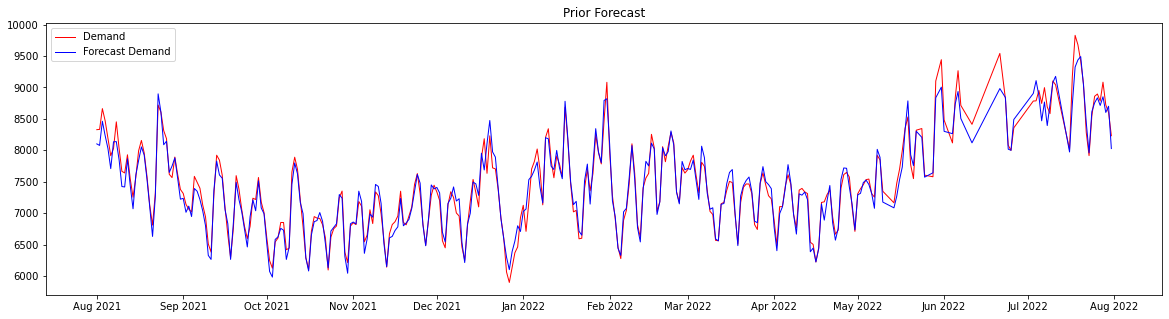

In [27]:
fig, ax = plt.subplots(figsize=(20,5))
forecast = ax.plot(Date, Forecast, linewidth=1, color='red')
test = ax.plot(Date, Test, linewidth=1, color='blue')
ax.legend([test, forecast], labels=["Demand", "Forecast Demand"])
ax.xaxis.set_major_locator(mdates.MonthLocator())
ax.xaxis.set_major_formatter(mdates.DateFormatter('%b %Y'))
ax.set_title("Prior Forecast")
plt.show()

In [28]:
# print prior model performance
mae1 = mean_absolute_error(Test, Forecast)
mse1 = mean_squared_error(Test, Forecast)
rmse1 = np.sqrt(mse1)
print("Mean Absolute Error: {:.2f}".format(mae1))
print("Root Mean Squared Error: {:.2f}".format(rmse1))

Mean Absolute Error: 112.60
Root Mean Squared Error: 146.63


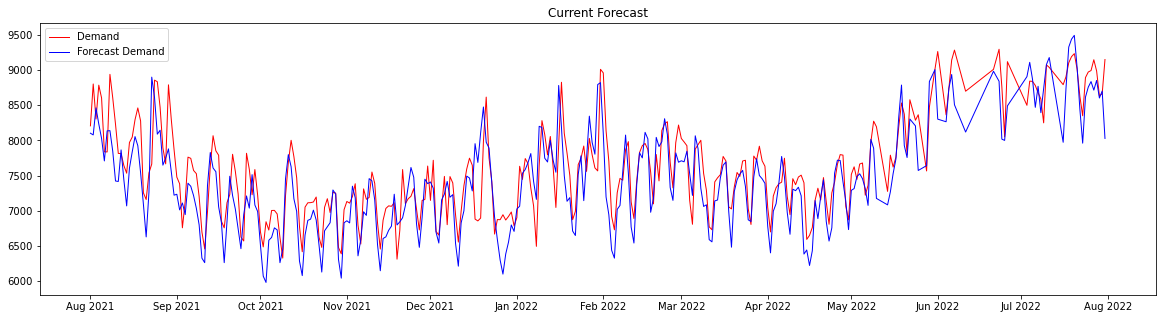

In [29]:
fig, ax = plt.subplots(figsize=(20,5))
forecast = ax.plot(Date, Pred, linewidth=1, color='red')
test = ax.plot(Date, Test, linewidth=1, color='blue')
ax.legend([test, forecast], labels=["Demand", "Forecast Demand"])
ax.xaxis.set_major_locator(mdates.MonthLocator())
ax.xaxis.set_major_formatter(mdates.DateFormatter('%b %Y'))
ax.set_title("Current Forecast")
plt.show()

In [30]:
# print current model performance
mae2 = mean_absolute_error(Test, Pred)
mse2 = mean_squared_error(Test, Pred)
rmse2 = np.sqrt(mse2)

print("Mean Absolute Error: {:.2f}".format(mae2))
print("Root Mean Squared Error: {:.2f}".format(rmse2))

Mean Absolute Error: 316.42
Root Mean Squared Error: 397.45


# SHAP

In [47]:
# renaming df columns to include name of feature (important for graphical representations)
X_train_scaled2 = X_train_scaled
X_train_scaled2.columns = ['MONTH','DAY','HUMIDITY','WINDSPEED','TOTALDEMAND','HOLIDAY','SOLAR','TEMPAVE','RRP','OUTPUT','MON','TUES','WED','THU','FRI','SAT','SUN']
print(X_train_scaled2)

         MONTH       DAY  HUMIDITY  WINDSPEED  TOTALDEMAND  HOLIDAY     SOLAR  \
0     0.000000  0.000000  0.582667   0.201285     0.210631      1.0  1.000000   
1     0.000000  0.033333  0.582667   0.201285     0.178184      0.0  0.663462   
2     0.000000  0.066667  0.626405   0.161452     0.149550      0.0  0.298077   
3     0.000000  0.100000  0.613899   0.386489     0.343004      0.0  0.173077   
4     0.000000  0.133333  0.734084   0.389422     0.367334      0.0  0.108974   
...        ...       ...       ...        ...          ...      ...       ...   
2015  0.545455  0.833333  0.267992   0.635553     0.619682      0.0  0.304487   
2016  0.545455  0.866667  0.367186   0.255089     0.534920      0.0  0.365385   
2017  0.545455  0.900000  0.419507   0.268615     0.512972      0.0  0.349359   
2018  0.545455  0.933333  0.282883   0.562435     0.541680      0.0  0.384615   
2019  0.545455  0.966667  0.285306   0.299102     0.671791      0.0  0.387821   

       TEMPAVE       RRP   

In [48]:
# explain the model's predictions using SHAP values

explainer = shap.TreeExplainer(best_model)
shap_values = explainer.shap_values(X_train_scaled2)

In [49]:
# visualise the first prediction's explanation
shap.initjs()
shap.force_plot(explainer.expected_value, shap_values[0,:], X_train_scaled2.iloc[0,:])

The above explanation shows features each contributing to push the model output from the base value (the average model output over the training dataset we passed) to the model output. Features pushing the prediction higher are shown in red, those pushing the prediction lower are in blue.

In [50]:
# visualize the training set predictions
shap.force_plot(explainer.expected_value, shap_values, X_train_scaled2)

To understand how a single feature effects the output of the model we can plot the SHAP value of that feature vs. the value of the feature for all the examples in a dataset. SHAP values represent a feature's responsibility for a change in the model output. Vertical dispersion represents interaction effects with other features. To help reveal these interactions dependence_plot automatically selects another feature for coloring.

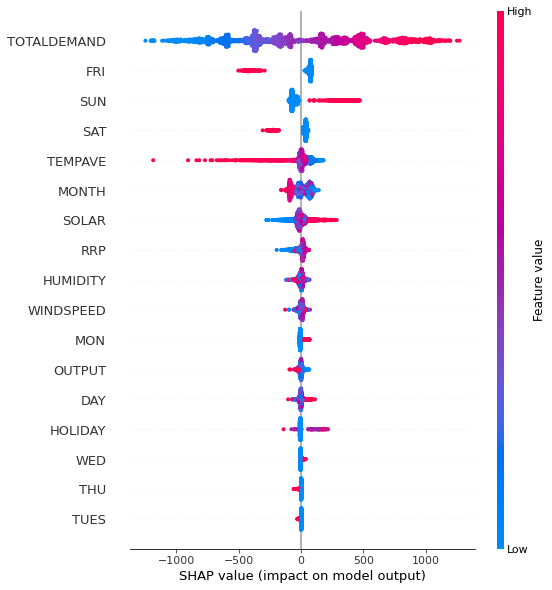

In [51]:
# summarize the effects of all the features
shap.summary_plot(shap_values, X_train_scaled2)

We can also just take the mean absolute value of the SHAP values for each feature to get a standard bar plot (produces stacked bars for multi-class outputs):

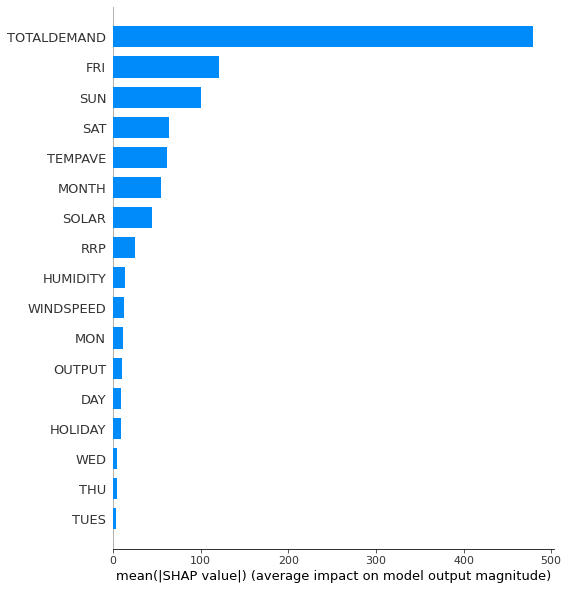

In [52]:
shap.summary_plot(shap_values, X_train_scaled2, plot_type="bar")